<a href="https://colab.research.google.com/github/MoncefDj/AI-DS-Masters/blob/main/TP4_DL_Sentence_auto_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 04: Sentence auto-complete with `LSTMs`

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import nltk
import re

## Upload Dataset

In [ ]:
# Specify the filename
input_file = '/content/data.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [ ]:
(data)[:1000] # view first few characters

"The Project Gutenberg eBook of Rena's experiment\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License included with this ebook or online\nat www.gutenberg.org. If you are not located in the United States,\nyou will have to check the laws of the country where you are located\nbefore using this eBook.\n\nTitle: Rena's experiment\n\nAuthor: Mary Jane Holmes\n\nRelease date: December 13, 2024 [eBook #74886]\n\nLanguage: English\n\nOriginal publication: United States: G. W. Dillingham Company\n\nCredits: Richard Tonsing and the Online Distributed Proofreading Team at https://www.pgdp.net (This book was produced from images made available by the HathiTrust Digital Library.)\n\n\n*** START OF THE PROJECT GUTENBERG EBOOK RENA'S EXPERIMENT ***\n\n\n[Illustration:\n\n  The figure standing close

In [ ]:
print(len(data))
data = data[:200000]

407781


## Data Cleaning and Tokenization

In [ ]:
# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

In [ ]:
# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized

# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)
tokenized_sentences[:10]

['the project gutenberg ebook of renas experiment',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever you may copy it give it away or reuse it under the terms',
 'of the project gutenberg license included with this ebook or online',
 'at wwwgutenbergorg if you are not located in the united states',
 'you will have to check the laws of the country where you are located',
 'before using this ebook',
 'title renas experiment',
 'author mary jane holmes']

In [ ]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model.
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.
"""
# Tokenize words
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index
"""
n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""

# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [ ]:
# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

## Split Dataset

In [ ]:
# Split data into training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.05, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

## LSTM Architecture

In [ ]:
from tensorflow.keras.layers import Dropout

# Define your model
model = Sequential()
model.add(Embedding(total_words, 250))  # Increased embedding dimensions
model.add(Bidirectional(LSTM(256)))  # Increased LSTM units
model.add(Dropout(0.4))  # Added dropout for regularization
model.add(Dense(total_words, activation='softmax'))

adam = Adam(learning_rate=0.005)  # Adjusted learning rate
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

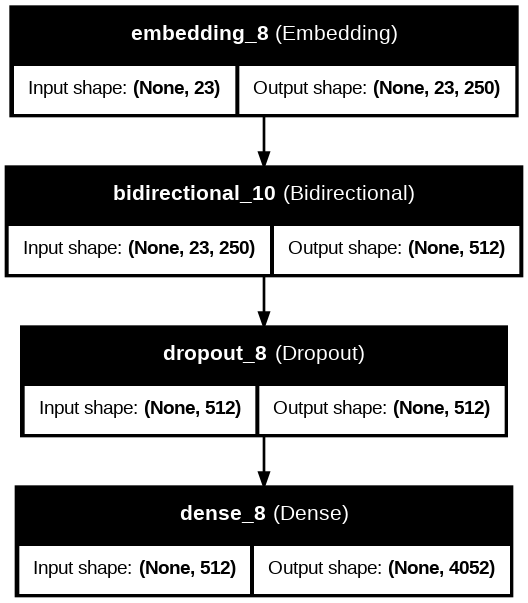

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Generate a visual diagram of the model
plot_model(
    model,
    to_file='model_architecture.png',  # Saves the image to this file
    show_shapes=True,  # Displays input/output shapes
    show_layer_names=True,  # Displays layer names
    dpi=96  # Image resolution
)


##Input Size
Embedding Layer: The input to the LSTM is first passed through an `Embedding` layer. This layer converts the input sequence of word indices into dense vectors of a fixed size (250 in this case).

LSTM Layer: The output of the Embedding layer is then fed to the LSTM layer. Since the Embedding layer produces vectors of size 250, this becomes the input size for the LSTM.

##LSTM Type
`Many-to-One`

## Model Summary

In [ ]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 23, 250)             │       1,013,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 512)                 │       1,038,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4052)                │       2,078,676 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,390,038 (47.26 MB)

 Trainable params: 4,130,012 (15.75 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,260,026 (31.51 MB)

# Train LSTM Model

In [ ]:
# Train the model for more epochs with early stopping
history = model.fit(X_train_temp, y_train_temp, epochs=15,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 283s 275ms/step - accuracy: 0.0649 - loss: 6.2948 - val_accuracy: 0.1241 - val_loss: 5.7163
Epoch 2/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 275s 271ms/step - accuracy: 0.1183 - loss: 5.4738 - val_accuracy: 0.1300 - val_loss: 5.6218
Epoch 3/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 277s 272ms/step - accuracy: 0.1495 - loss: 4.9720 - val_accuracy: 0.1101 - val_loss: 5.6596
Epoch 4/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 321s 272ms/step - accuracy: 0.1728 - loss: 4.5836 - val_accuracy: 0.1159 - val_loss: 5.8311
Epoch 5/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 276s 271ms/step - accuracy: 0.2034 - loss: 4.1878 - val_accuracy: 0.1124 - val_loss: 5.9441
Epoch 6/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 275s 271ms/step - accuracy: 0.2329 - loss: 3.8421 - val_accuracy: 0.1183 - val_loss: 6.1036
Epoch 7/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 320s 269ms/step - accuracy: 0.2587 - loss: 3.5589 - val_accuracy: 0.1101 - val_loss: 6.2851
Epoch 8/15
1015/1015 ━━━━━━━━━━━━━━━━━━━━ 323s 271ms/step - ac

## Evaluate the Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Predictions on the Test Set
y_pred_probs = model.predict(X_test, verbose=0)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels

# True Labels
y_true = np.argmax(y_test, axis=1)  # Get true class labels

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_true, y_pred, average='weighted')  # Use 'weighted' for multi-class

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.1077
Precision: 0.0847
Recall: 0.1077


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def calculate_metrics_top_five(model, tokenizer, X_test, y_test):
    """
    Calculates accuracy, precision, and recall based on top-five predictions.

    Args:
        model: The trained model.
        tokenizer: The tokenizer used for text processing.
        X_test: The test data.
        y_test: The true labels for the test data.

    Returns:
        accuracy, precision, recall: The calculated metrics.
    """
    y_true = np.argmax(y_test, axis=1)  # Get true class labels
    correct_predictions = 0
    total_predictions = len(y_true)
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for i in range(total_predictions):
        seed_text_tokens = X_test[i]  # Get the input tokens for the current sample
        seed_text = tokenizer.sequences_to_texts([seed_text_tokens])[0]  # Convert tokens back to text

        top_five_words = predict_top_five_words(model, tokenizer, seed_text)  # Get top-five predictions
        top_five_indexes = [tokenizer.word_index[word] for word in top_five_words]  # Get indexes of top-five words

        if y_true[i] in top_five_indexes:
            correct_predictions += 1
            true_positives += 1
        else:
            false_negatives += 1
            false_positives += len(top_five_indexes)  # Count all top-five predictions as false positives if none are correct


    accuracy = correct_predictions / total_predictions
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0  # Avoid division by zero
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0  # Avoid division by zero

    return accuracy, precision, recall

# Calculate metrics using the new function
accuracy, precision, recall = calculate_metrics_top_five(model, tokenizer, X_test, y_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.2295
Precision: 0.0562
Recall: 0.2295


##Print some pridections

In [ ]:
from IPython.display import HTML, display

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words

def predict_and_display_top_five_words2(seed_text, model, tokenizer):
    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = f"<h1>Sentence AutoCompletion With Top Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    display(HTML(f'{heading_app} <br> <hr> {output_text}'))  # Display the output using display(HTML())




In [ ]:
# Test the function
seed_text = "so"
predict_and_display_top_five_words2(seed_text, model, tokenizer)

In [ ]:
# Test 2:
# Test the function
seed_text = "I have"
predict_and_display_top_five_words2(seed_text, model, tokenizer)

In [ ]:
# Test 3:
# Test the function
seed_text = "did"
predict_and_display_top_five_words2(seed_text, model, tokenizer)

In [ ]:
# Test 3:
seed_text = "the fourth "
predict_and_display_top_five_words2(seed_text, model, tokenizer)